<h1 aligh='center'>Credit Fraud Detector</h1> 



#### How it happens:
  >> Lost Cards.
  >> Misuse of card details.
  >> Fake phone calls disclosing your details.

#### Main challenges involved in credit card fraud detection are:

1. Enormous Data is processed every day and the model build must be fast enough to respond to the scam in time.

2. Imbalanced Data i.e most of the transactions (99.8%) are not fraudulent which makes it really hard for detecting the fraudulent ones.

3. Data availability as the data is mostly private.

4. Adaptive techniques used against the model by the scammers
#### Our Goals: 
Understand the little distribution of the "little" data that was provided to us.
Create a 50/50 sub-dataframe ratio of "Fraud" and "Non-Fraud" transactions. (NearMiss Algorithm)
Determine the Classifiers we are going to use and decide which one has a higher accuracy.
Create a Neural Network and compare the accuracy to our best classifier.
Understand common mistaked made with imbalanced datasets.
#### Outline: 
I. Understanding our data

    a) [Gather Sense of our data](#gather)

II. Preprocessing

    a) Scaling and Distributing
    b) Splitting the Data


III. Random UnderSampling and Oversampling

    a) Distributing and Correlating
    b) Anomaly Detection
    c) Dimensionality Reduction and Clustering (t-SNE)
    d) Classifiers
    e) A Deeper Look into Logistic Regression
    f) Oversampling with SMOTE


IV. Testing

    a) Testing with Logistic Regression
    b) Neural Networks Testing (Undersampling vs Oversampling)

#### Correcting Previous Mistakes from Imbalanced Datasets: 
Never test on the oversampled or undersampled dataset.
If we want to implement cross validation, remember to oversample or undersample your training data during cross-validation, not before!
Don't use accuracy score as a metric with imbalanced datasets (will be usually high and misleading), instead use f1-score, precision/recall score or confusion matrix

In [ ]:
#Importing all the wanted libraries


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections


# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")


In [ ]:
#Take the datasets
from google.colab import drive
drive.mount('/content/drive')
df=pd.read_csv('drive/My Drive/ML Project/creditcard.csv')


In [ ]:
df.head(5)

In [ ]:
df.describe()

In [ ]:
df.isnull().sum()

In [ ]:
df.columns

In [ ]:
print("Non frauds",round(df['Class'].value_counts()[0]/len(df)*100,2),'%')
print("Frauds",round(df['Class'].value_counts()[1]/len(df)*100,2),'%')

In [ ]:
colors=['red','blue']
sns.countplot('Class',data=df,palette=colors)
plt.title('Class Distribution \n (0:No fraud || 1:Fraud)',fontsize=15)

**Distributions:** By seeing the distributions we can have an idea how skewed are these features, we can also see further distributions of the other features. There are techniques that can help the distributions be less skewed which will be implemented .

In [ ]:
fig,ax=plt.subplots(1,2,figsize=(25,8))
amount_val=df['Amount'].values
time_val=df['Time'].values


sns.distplot(amount_val,ax=ax[0],color='blue')
ax[0].set_title('Distribution of Transaction Amount',fontsize=18)
ax[0].set_xlim([min(amount_val),max(amount_val)])


sns.distplot(time_val,ax=ax[1],color='b')
ax[1].set_title('Distribution of Transaction Time',fontsize=18)
ax[1].set_xlim([min(time_val),max(time_val)])

plt.show()

<h2> Scaling </h2>
<a id="distributing"></a>
In this phase we will first scale the columns comprise of <b>Time</b> and <b>Amount </b>. Time and amount should be scaled as the other columns. On the other hand, we need to also create a sub sample of the dataframe in order to have an equal amount of Fraud and Non-Fraud cases, helping our algorithms better understand patterns that determines whether a transaction is a fraud or not.

<h3> What is a sub-Sample?</h3>
In this scenario, our subsample will be a dataframe with a 50/50 ratio of fraud and non-fraud transactions. Meaning our sub-sample will have the same amount of fraud and non fraud transactions.

<h3> Why do we create a sub-Sample?</h3>
In the beginning we saw that the original dataframe was heavily imbalanced! Using the original dataframe  will cause the following issues:
<ul>
<li><b>Overfitting: </b>Our classification models will assume that in most cases there are no frauds! What we want for our model is to be certain when a fraud occurs. </li>
<li><b>Wrong Correlations:</b> Although we don't know what the "V" features stand for, it will be useful to understand how each of this features influence the result (Fraud or No Fraud) by having an imbalance dataframe we are not able to see the true correlations between the class and features. </li>
</ul>

<h3>Summary: </h3> 
<ul>
<li> <b>Scaled amount </b> and <b> scaled time </b> are the columns with scaled values. </li>
<li> There are <b>492 cases </b> of fraud in our dataset so we can randomly get 492 cases of non-fraud to create our new sub dataframe. </li>
<li>We concat the 492 cases of fraud and non fraud, <b>creating a new sub-sample. </b></li>
</ul>

In [ ]:
from sklearn.preprocessing import RobustScaler as rs

df['scaled_amount']=rs().fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time']=rs().fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'],axis=1,inplace=True)

In [ ]:
scaled_amount=df['scaled_amount']
scaled_time=df['scaled_time']


df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)


df.head(5)

### Splitting the Data (Original DataFrame)
<a id="splitting"></a>
Before proceeding with the <b> Random UnderSampling technique</b> we have to separate the orginal dataframe. <b> Why? for testing purposes, remember although we are splitting the data when implementing Random UnderSampling or OverSampling techniques, we want to test our models on the original testing set not on the testing set created by either of these techniques.</b> The main goal is to fit the model either with the dataframes that were undersample and oversample (in order for our models to detect the patterns), and test it on the original testing set. # Splitting of Data(Original DataFrame)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

X = df.drop('Class', axis=1)
y = df['Class']

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

    
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values


train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

# Random Under-Sampling:
In this phase of the project we will implement *"Random Under Sampling"* which basically consists of removing data in order to have a more <b> balanced dataset </b> and thus avoiding our models to overfitting.

#### Steps:
<ul>
<li>The first thing we have to do is determine how <b>imbalanced</b> is our class (use "value_counts()" on the class column to determine the amount for each label)  </li>
<li>Once we determine how many instances are considered <b>fraud transactions </b> (Fraud = "1") , we should bring the <b>non-fraud transactions</b> to the same amount as fraud transactions (assuming we want a 50/50 ratio), this will be equivalent to 492 cases of fraud and 492 cases of non-fraud transactions.  </li>
<li> After implementing this technique, we have a sub-sample of our dataframe with a 50/50 ratio with regards to our classes. Then the next step we will implement is to <b>shuffle the data</b> to see if our models can maintain a certain accuracy everytime we run this script.</li>
</ul>

**Note:** The main issue with "Random Under-Sampling" is that we run the risk that our classification models will not perform as accurate as we would like to since there is a great deal of <b>information loss</b> (bringing 492 non-fraud transaction  from 284,315 non-fraud transaction)

In [ ]:
df = df.sample(frac=1)

fraud_df=df.loc[df['Class']==1]
non_fraud_df=df.loc[df['Class']==0][:492]

normal_distributed_df=pd.concat([fraud_df,non_fraud_df])

new_df=normal_distributed_df.sample(frac=1,random_state=42)

new_df.head(5)

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
274156,2.229302,0.953782,1.670494,-0.651169,-1.078460,3.196717,0.259251,1.198840,-0.128499,0.084879,-1.896266,2.161042,-0.511676,0.683080,0.907592,-0.289932,-3.194578,-1.221126,-0.360816,1.134447,-1.505360,-0.277344,-0.165394,-0.118818,-0.099720,0.227623,0.197328,0.150260,-0.034735,-0.028186,0
8845,0.117236,-0.852888,-4.727713,3.044469,-5.598354,5.928191,-2.190770,-1.529323,-4.487422,0.916392,-1.307010,-4.138891,5.149409,-11.124019,0.543068,-7.840942,0.743634,-6.777069,-9.931765,-4.093021,1.504925,-0.207759,0.650988,0.254983,0.628843,-0.238128,-0.671332,-0.033590,-1.331777,0.705698,1
234892,2.179837,0.745627,1.761027,-0.301155,-2.624558,0.230814,0.279343,-1.658535,0.627321,-0.436140,0.497354,-1.008908,-0.210576,-0.474163,-0.751908,-1.823802,0.333071,0.508622,1.736232,0.096677,-0.039981,0.187133,-0.196929,-0.811278,0.028536,-0.304623,-0.266685,1.135898,-0.150053,-0.002925,0
102782,-0.033676,-0.191908,1.232604,-0.548931,1.087873,0.894082,-1.433055,-0.356797,-0.717492,0.003167,-0.100397,0.543187,-1.039417,0.285262,-0.206007,-0.498522,-1.064108,-2.156037,0.564761,0.837857,-0.728990,-0.576274,-0.448671,-0.517568,0.012833,0.699217,0.527258,-0.322607,0.080805,0.035427,1
197586,6.409837,0.556797,-0.361428,1.133472,-2.971360,-0.283073,0.371452,-0.574680,4.031513,-0.934398,-0.768255,-2.248115,-0.482409,-0.690550,0.181275,-2.372552,-0.006868,0.146399,1.759314,1.083040,-0.391048,-0.025862,0.110815,0.563861,-0.408436,-0.880079,1.408392,-0.137402,-0.001250,-0.182751,1


# Equally Distributing and Correlating
Now that we have our dataframe correctly balanced, we can go further with our <b>analysis</b> and <b>data preprocessing</b>.


Distribution of the Classes in the subsample dataset
1    0.5
0    0.5
Name: Class, dtype: float64


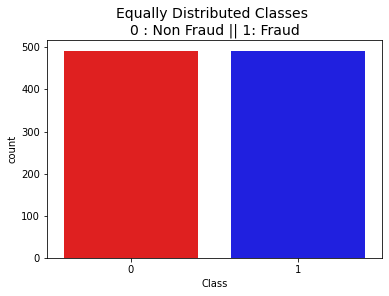

In [ ]:
print('Distribution of the Classes in the subsample dataset')
print(new_df['Class'].value_counts()/len(new_df))



sns.countplot('Class', data=new_df, palette=colors)
plt.title('Equally Distributed Classes \n0 : Non Fraud || 1: Fraud', fontsize=14)
plt.show()

<h3> Correlation Matrices </h3>
Correlation matrices are the essence of understanding our data. We want to know if there are features that influence heavily in whether a specific transaction is a fraud. However, it is important that we use the correct dataframe (subsample)  in order for us to see which features have a high positive or negative correlation with regards to fraud transactions.

### Summary and Explanation: 
<ul>
<li><b>Negative Correlations: </b>V17, V14, V12 and V10 are negatively correlated. Notice how the lower these values are, the more likely the end result will be a fraud transaction.  </li>
<li> <b> Positive Correlations: </b> V2, V4, V11, and V19 are positively correlated. Notice how the higher these values are, the more likely the end result will be a fraud transaction. </li>
<li> <b>BoxPlots: </b>  We will use boxplots to have a better understanding of the distribution of these features in fradulent and non fradulent transactions. </li>
</ul>


**Note:** We have to make sure we use the subsample in our correlation matrix or else our correlation matrix will be affected by the high imbalance between our classes. This occurs due to the high class imbalance in the original dataframe.

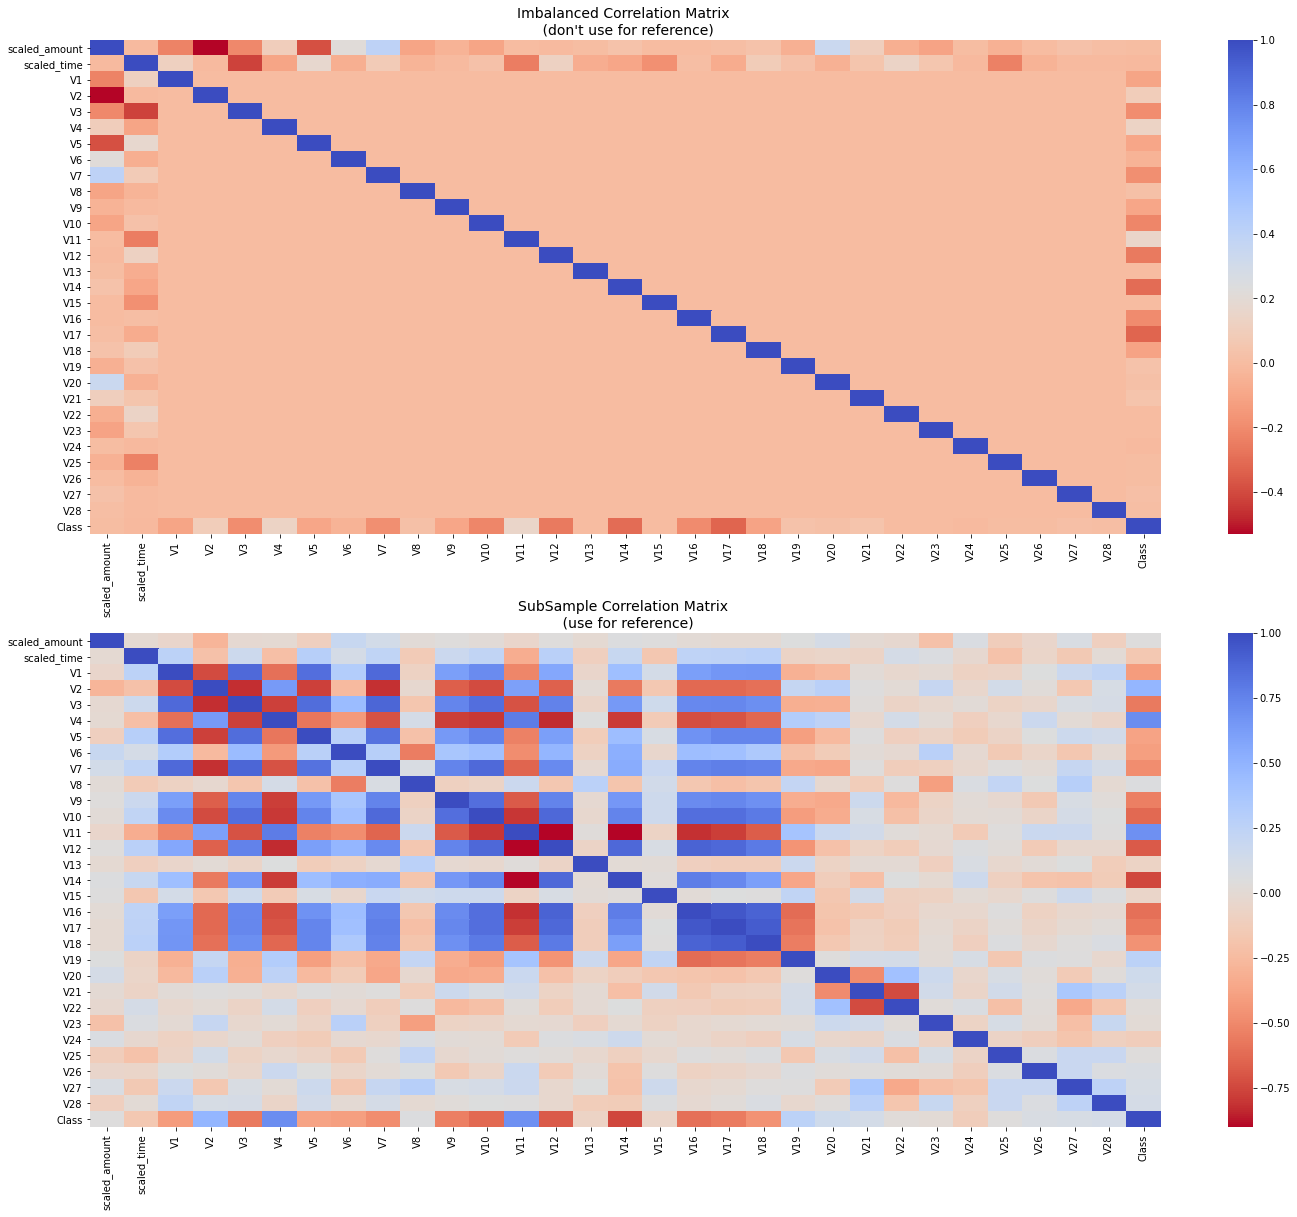

In [ ]:
# Make sure we use the subsample in our correlation

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

# Entire DataFrame
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix \n (don't use for reference)", fontsize=14)


sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('SubSample Correlation Matrix \n (use for reference)', fontsize=14)
plt.show()

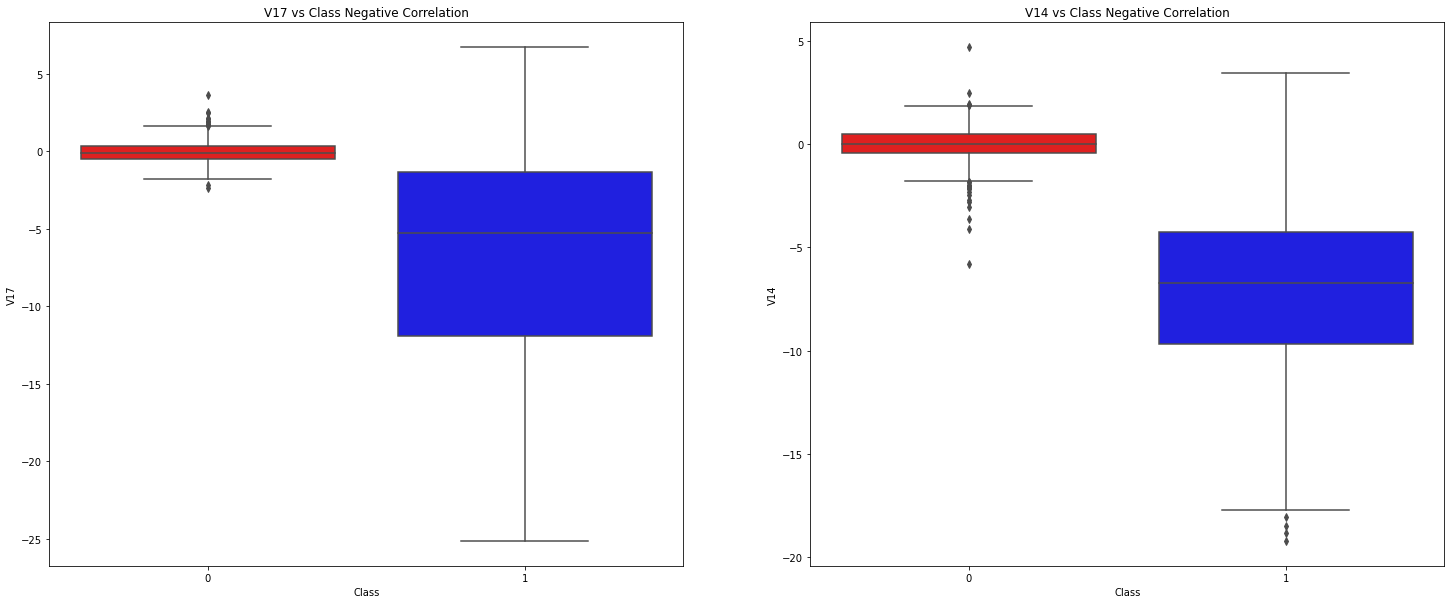

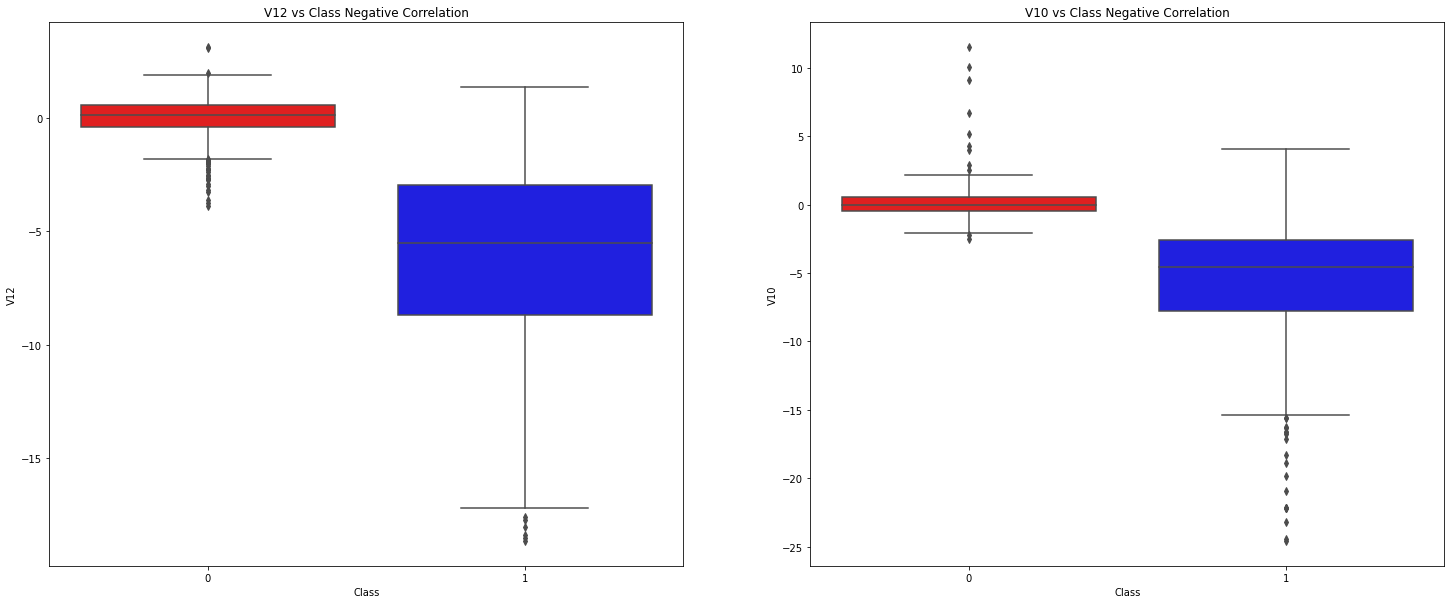

In [ ]:
f, axes = plt.subplots(ncols=2, figsize=(25,10))

# Negative Correlations with our Class (The lower our feature value the more likely it will be a fraud transaction)
sns.boxplot(x="Class", y="V17", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('V17 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V14", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('V14 vs Class Negative Correlation')

f, axes = plt.subplots(ncols=2, figsize=(25,10))

sns.boxplot(x="Class", y="V12", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('V12 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V10", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('V10 vs Class Negative Correlation')

plt.show()

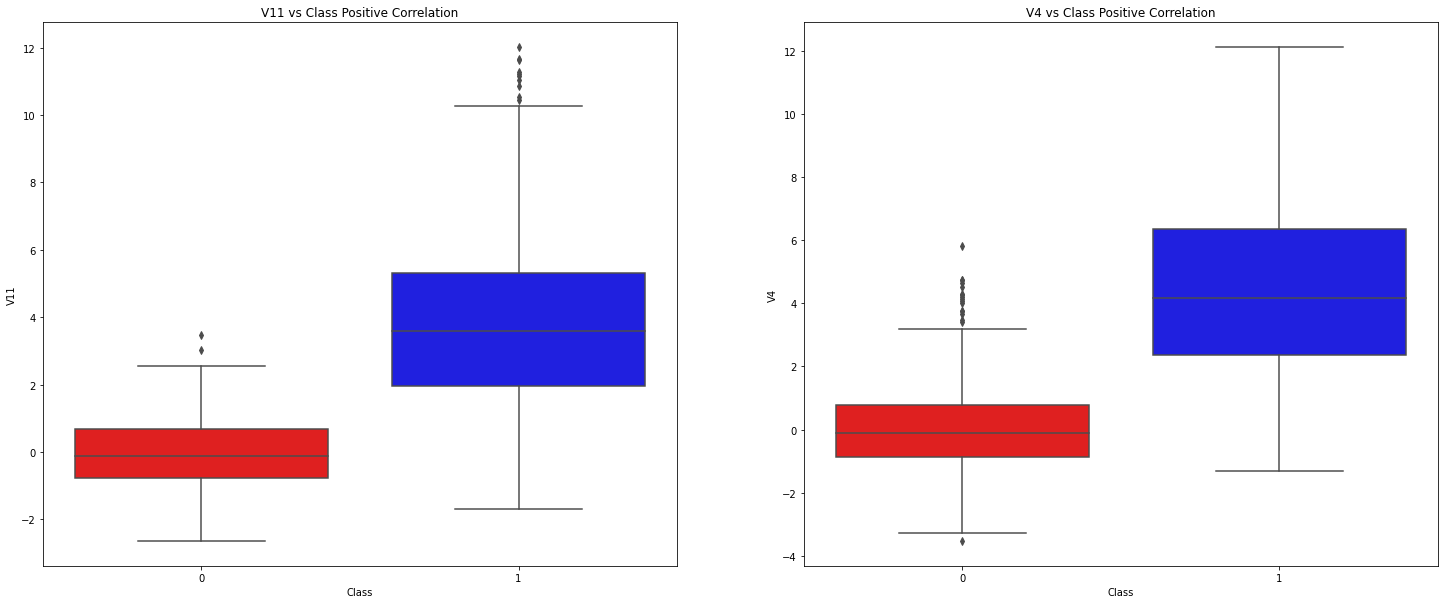

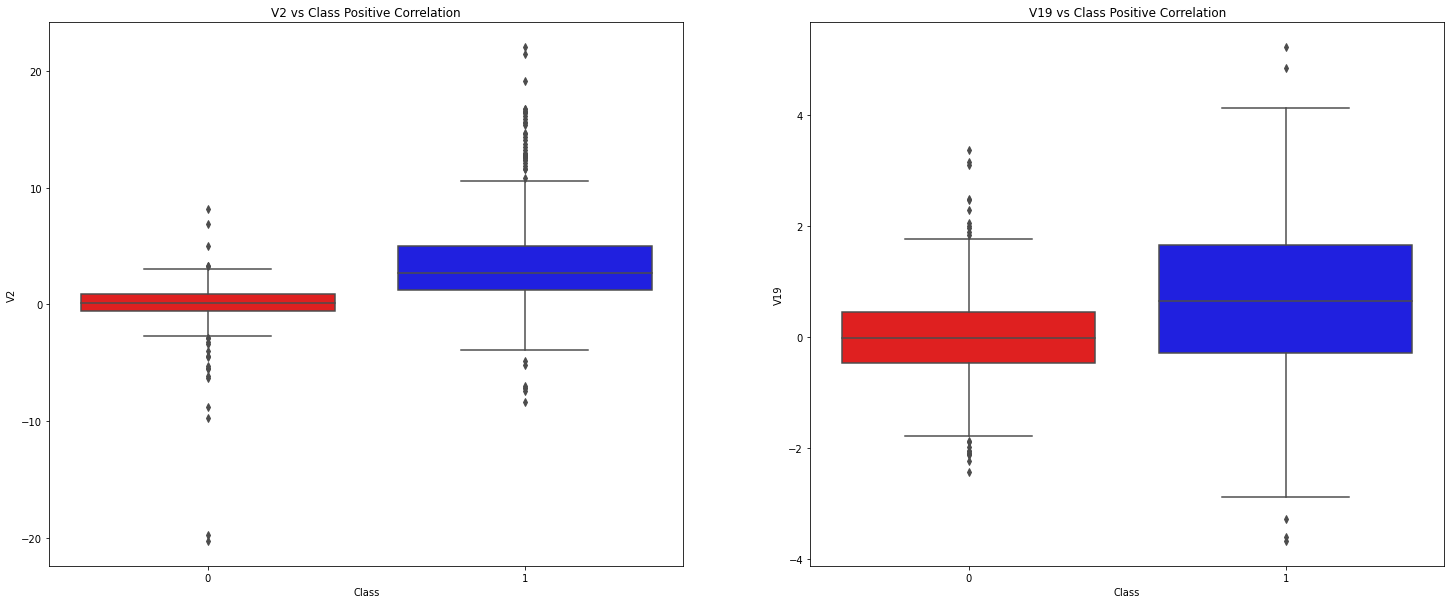

In [ ]:
f, axes = plt.subplots(ncols=2, figsize=(25,10))

# Positive correlations (The higher the feature the probability increases that it will be a fraud transaction)
sns.boxplot(x="Class", y="V11", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('V11 vs Class Positive Correlation')

sns.boxplot(x="Class", y="V4", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('V4 vs Class Positive Correlation')

f, axes = plt.subplots(ncols=2, figsize=(25,10))


sns.boxplot(x="Class", y="V2", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('V2 vs Class Positive Correlation')


sns.boxplot(x="Class", y="V19", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('V19 vs Class Positive Correlation')

plt.show()


# Anomaly Detection:
    * Interquartile Range(IQR)
    * Boxplots
    * Outlayer Removal Tradeoff
    
Our main aim in this section is to remove "extreme outliers" from features that have a high correlation with our classes. This will have a positive impact on the accuracy of our models.  <br><br>


### Interquartile Range Method:
<ul>
<li> <b>Interquartile Range (IQR): </b> We calculate this by the difference between the 75th percentile and 25th percentile. Our aim is to create a threshold beyond the 75th and 25th percentile that in case some instance pass this threshold the instance will be deleted.  </li>
<li> <b>Boxplots: </b> Besides easily seeing the 25th and 75th percentiles (both end of the squares) it is also easy to see extreme outliers (points beyond the lower and higher extreme). </li>
</ul>

### Outlier Removal Tradeoff:
We have to be careful as to how far do we want the threshold for removing outliers. We determine the threshold by multiplying a number (ex: 1.5) by the (Interquartile Range). The higher this threshold is, the less outliers will detect (multiplying by a higher number ex: 3), and the lower this threshold is the more outliers it will detect.  <br><br>

**The Tradeoff:**
The lower the threshold the more outliers it will remove however, we want to focus more on "extreme outliers" rather than just outliers. Why? because we might run the risk of information loss which will cause our models to have a lower accuracy. You can play with this threshold and see how it affects the accuracy of our classification models.

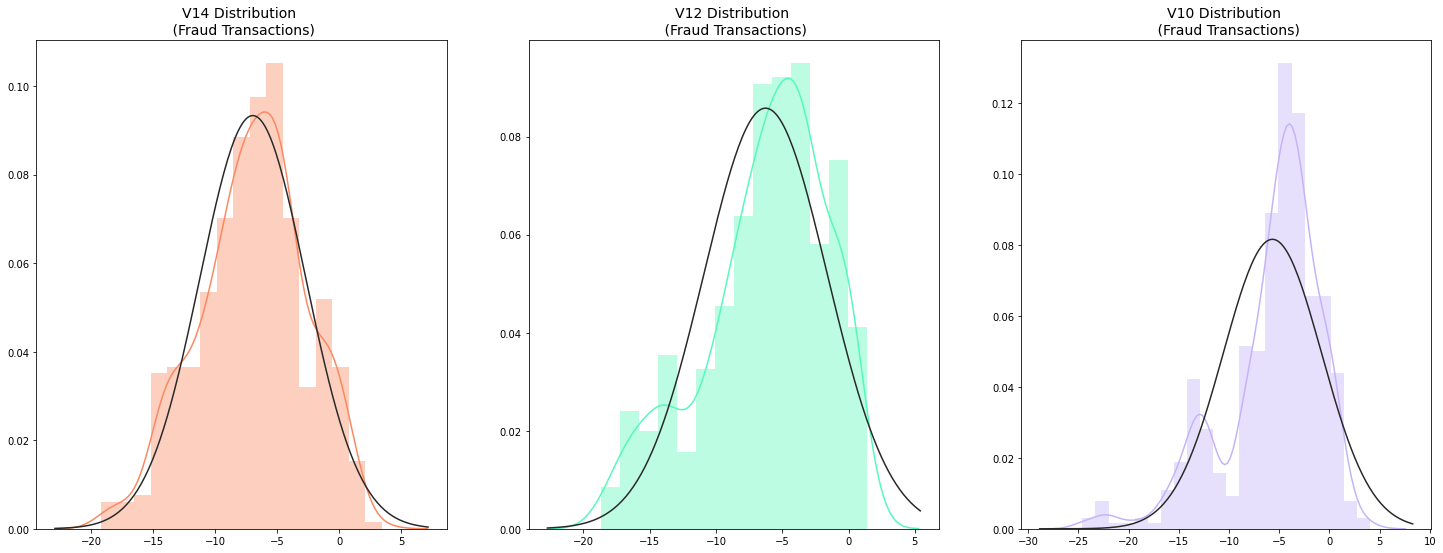

In [ ]:
from scipy.stats import norm

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(25, 9))

v14_fraud_dist = new_df['V14'].loc[new_df['Class'] == 1].values
sns.distplot(v14_fraud_dist,ax=ax1, fit=norm, color='#FB8861')
ax1.set_title('V14 Distribution \n (Fraud Transactions)', fontsize=14)

v12_fraud_dist = new_df['V12'].loc[new_df['Class'] == 1].values
sns.distplot(v12_fraud_dist,ax=ax2, fit=norm, color='#56F9BB')
ax2.set_title('V12 Distribution \n (Fraud Transactions)', fontsize=14)


v10_fraud_dist = new_df['V10'].loc[new_df['Class'] == 1].values
sns.distplot(v10_fraud_dist,ax=ax3, fit=norm, color='#C5B3F9')
ax3.set_title('V10 Distribution \n (Fraud Transactions)', fontsize=14)

plt.show()

In [ ]:
# # -----> V14 Removing Outliers (Highest Negative Correlated with Labels)
v14_fraud = new_df['V14'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v14_fraud, 25), np.percentile(v14_fraud, 75)
print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
v14_iqr = q75 - q25
print('iqr: {}'.format(v14_iqr))

v14_cut_off = v14_iqr * 1.5
v14_lower, v14_upper = q25 - v14_cut_off, q75 + v14_cut_off
print('Cut Off: {}'.format(v14_cut_off))
print('V14 Lower: {}'.format(v14_lower))
print('V14 Upper: {}'.format(v14_upper))

outliers = [x for x in v14_fraud if x < v14_lower or x > v14_upper]
print('Feature V14 Outliers for Fraud Cases: {}'.format(len(outliers)))
print('V10 outliers:{}'.format(outliers))

new_df = new_df.drop(new_df[(new_df['V14'] > v14_upper) | (new_df['V14'] < v14_lower)].index)
print('----' * 44)

# -----> V12 removing outliers from fraud transactions
v12_fraud = new_df['V12'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v12_fraud, 25), np.percentile(v12_fraud, 75)
v12_iqr = q75 - q25

v12_cut_off = v12_iqr * 1.5
v12_lower, v12_upper = q25 - v12_cut_off, q75 + v12_cut_off
print('V12 Lower: {}'.format(v12_lower))
print('V12 Upper: {}'.format(v12_upper))
outliers = [x for x in v12_fraud if x < v12_lower or x > v12_upper]
print('V12 outliers: {}'.format(outliers))
print('Feature V12 Outliers for Fraud Cases: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V12'] > v12_upper) | (new_df['V12'] < v12_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))
print('----' * 44)


# Removing outliers V10 Feature
v10_fraud = new_df['V10'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v10_fraud, 25), np.percentile(v10_fraud, 75)
v10_iqr = q75 - q25

v10_cut_off = v10_iqr * 1.5
v10_lower, v10_upper = q25 - v10_cut_off, q75 + v10_cut_off
print('V10 Lower: {}'.format(v10_lower))
print('V10 Upper: {}'.format(v10_upper))
outliers = [x for x in v10_fraud if x < v10_lower or x > v10_upper]
print('V10 outliers: {}'.format(outliers))
print('Feature V10 Outliers for Fraud Cases: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V10'] > v10_upper) | (new_df['V10'] < v10_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))

Quartile 25: -9.692722964972385 | Quartile 75: -4.282820849486866
iqr: 5.409902115485519
Cut Off: 8.114853173228278
V14 Lower: -17.807576138200663
V14 Upper: 3.8320323237414122
Feature V14 Outliers for Fraud Cases: 4
V10 outliers:[-18.8220867423816, -19.2143254902614, -18.4937733551053, -18.049997689859396]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
V12 Lower: -17.3430371579634
V12 Upper: 5.776973384895937
V12 outliers: [-18.4311310279993, -18.047596570821604, -18.683714633344298, -18.553697009645802]
Feature V12 Outliers for Fraud Cases: 4
Number of Instances after outliers removal: 975
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
V10 Lower: -14.89885463232024
V10 Upper: 4.920334958342141
V10 outliers: [-16.7460441053944, -

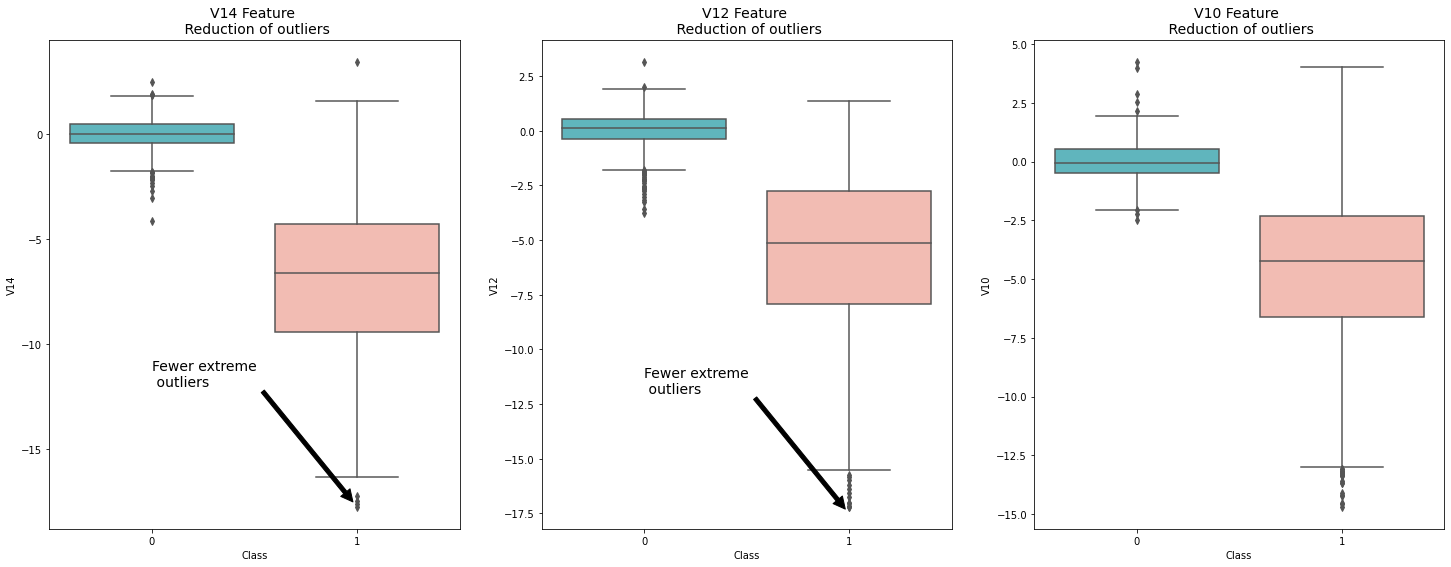

In [ ]:
f,(ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25,9))

colors = ['#50c2cc', '#fcb4a9']
# Boxplots with outliers removed
# Feature V14
sns.boxplot(x="Class", y="V14", data=new_df,ax=ax1, palette=colors)
ax1.set_title("V14 Feature \n Reduction of outliers", fontsize=14)
ax1.annotate('Fewer extreme \n outliers', xy=(0.98, -17.5), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

# Feature 12
sns.boxplot(x="Class", y="V12", data=new_df, ax=ax2, palette=colors)
ax2.set_title("V12 Feature \n Reduction of outliers", fontsize=14)
ax2.annotate('Fewer extreme \n outliers', xy=(0.98, -17.3), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

# Feature V10
sns.boxplot(x="Class", y="V10", data=new_df, ax=ax3, palette=colors)
ax3.set_title("V10 Feature \n Reduction of outliers", fontsize=14)
ax3.annotate('Fewer extreme \n outliers', xy=(0.95, -16.5), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)


plt.show()


# Dimentionality Reduction and Clustering


<h3>Understanding t-SNE:  </h3>
In order to understand this algorithm you have to understand the following terms: <br>
<ul>
<li> <b> Euclidean Distance </b></li>
<li> <b>Conditional Probability</b> </li>
<li><b>Normal and T-Distribution Plots</b> </li>

In [ ]:
# New_df is from the random undersample data (fewer instances)
X = new_df.drop('Class', axis=1)
y = new_df['Class']


# T-SNE Implementation
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))


T-SNE took 7.1 s


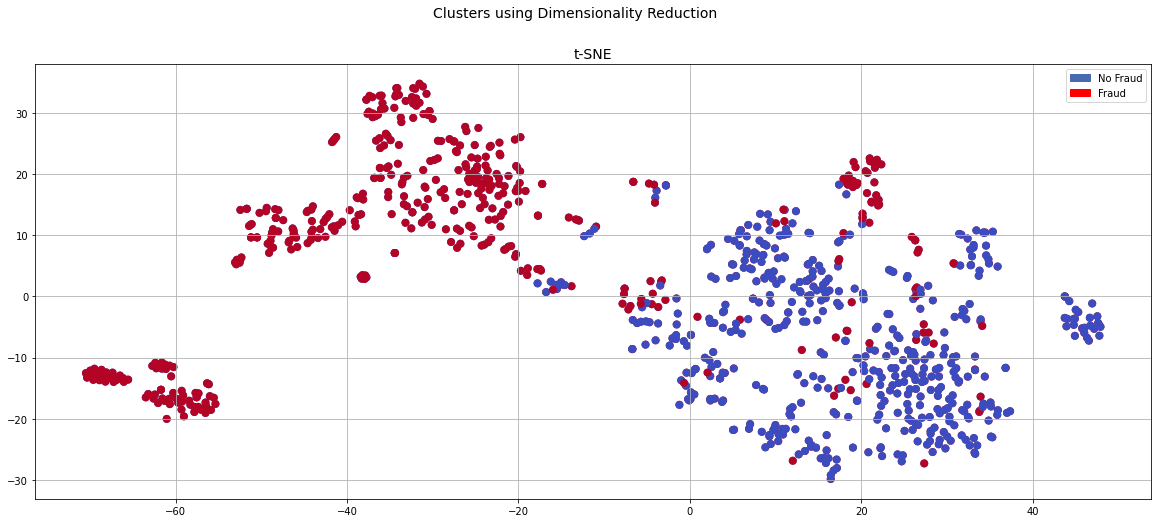

In [ ]:
f, (ax1) = plt.subplots(1, figsize=(20,8))
# labels = ['No Fraud', 'Fraud']
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)


blue_patch = mpatches.Patch(color='#486bb0', label='No Fraud')
red_patch = mpatches.Patch(color='#fc0000', label='Fraud')


# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)

ax1.grid(True)

ax1.legend(handles=[blue_patch, red_patch])



plt.show()


# Neural Networks Testing Random UnderSampling Data vs OverSampling (SMOTE)

### Our Main Goal:
Our main goal is to explore how our simple neural network behaves in both the random undersample and oversample dataframes and see whether they can predict accuractely both non-fraud and fraud cases. Why not only focus on fraud? Imagine you were a cardholder and after you purchased an item your card gets blocked because the bank's algorithm thought your purchase was a fraud. That's why we shouldn't emphasize only in detecting fraud cases but we should also emphasize correctly categorizing non-fraud transactions.

### The Confusion Matrix:
Here is again, how the confusion matrix works:

Upper Left Square: The amount of correctly classified by our model of no fraud transactions.
Upper Right Square: The amount of incorrectly classified transactions as fraud cases, but the actual label is no fraud .
Lower Left Square: The amount of incorrectly classified transactions as no fraud cases, but the actual label is fraud .
Lower Right Square: The amount of correctly classified by our model of fraud transactions.

### Keras || Random UnderSampling:
<ul>
<li><b>Dataset: </b> In this final phase of testing we will fit this model in the <b>random undersampled subset</b>  and <b> oversampled dataset (SMOTE) </b>in order to predict the final result using the <b>original dataframe testing data.</b> </li>
<li>  <b>Neural Network Structure: </b> As stated previously, this will be a simple model composed of one input layer (where the number of nodes equals the number of features) plus bias node, one hidden layer with 32 nodes and one output node composed of two possible results 0 or 1 (No fraud or fraud). </li>
<li> <b>Other characteristics:</b> The learning rate will be 0.001, the optimizer we will use is the AdamOptimizer, the activation function that is used in this scenario is "Relu" and for the final outputs we will use sparse categorical cross entropy, which gives the probability whether an instance case is no fraud or fraud (The prediction will pick the highest probability between the two.) </li>
</ul>

In [ ]:
X = new_df.drop('Class', axis=1)
y = new_df['Class']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [ ]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy

n_inputs = X_train.shape[1]

undersample_model = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])

Using TensorFlow backend.


In [ ]:
undersample_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                992       
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 66        
Total params: 1,988
Trainable params: 1,988
Non-trainable params: 0
_________________________________________________________________


In [ ]:
undersample_model.compile(Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
undersample_model.fit(X_train, y_train, validation_split=0.2, batch_size=25, epochs=20, shuffle=True, verbose=2)

Train on 603 samples, validate on 151 samples
Epoch 1/20
 - 0s - loss: 0.5806 - accuracy: 0.6567 - val_loss: 0.4672 - val_accuracy: 0.6821
Epoch 2/20
 - 0s - loss: 0.3922 - accuracy: 0.8242 - val_loss: 0.3717 - val_accuracy: 0.8808
Epoch 3/20
 - 0s - loss: 0.3091 - accuracy: 0.9055 - val_loss: 0.3071 - val_accuracy: 0.9272
Epoch 4/20
 - 0s - loss: 0.2527 - accuracy: 0.9171 - val_loss: 0.2667 - val_accuracy: 0.9338
Epoch 5/20
 - 0s - loss: 0.2122 - accuracy: 0.9287 - val_loss: 0.2435 - val_accuracy: 0.9338
Epoch 6/20
 - 0s - loss: 0.1837 - accuracy: 0.9287 - val_loss: 0.2356 - val_accuracy: 0.9338
Epoch 7/20
 - 0s - loss: 0.1637 - accuracy: 0.9370 - val_loss: 0.2304 - val_accuracy: 0.9338
Epoch 8/20
 - 0s - loss: 0.1485 - accuracy: 0.9436 - val_loss: 0.2299 - val_accuracy: 0.9338
Epoch 9/20
 - 0s - loss: 0.1389 - accuracy: 0.9436 - val_loss: 0.2280 - val_accuracy: 0.9338
Epoch 10/20
 - 0s - loss: 0.1335 - accuracy: 0.9453 - val_loss: 0.2283 - val_accuracy: 0.9338
Epoch 11/20
 - 0s - los

In [ ]:
undersample_predictions = undersample_model.predict(original_Xtest, batch_size=200, verbose=0)

In [ ]:
undersample_fraud_predictions = undersample_model.predict_classes(original_Xtest, batch_size=200, verbose=0)

In [ ]:
import itertools

# Create a confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[55041  1822]
 [    6    92]]
Confusion matrix, without normalization
[[56863     0]
 [    0    98]]


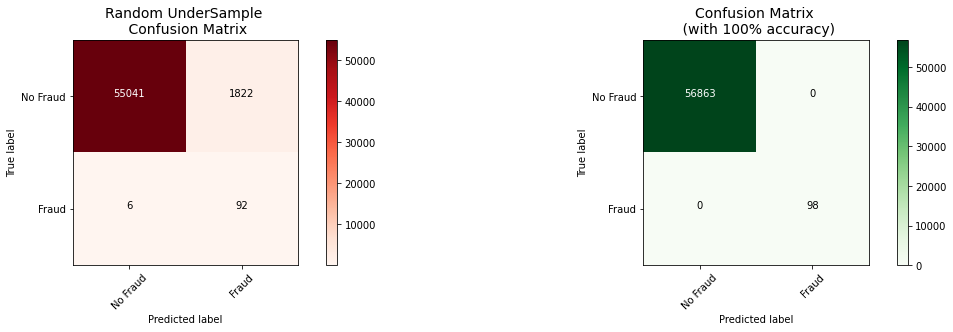

In [ ]:
from sklearn.metrics import confusion_matrix

undersample_cm = confusion_matrix(original_ytest, undersample_fraud_predictions)
actual_cm = confusion_matrix(original_ytest, original_ytest)
labels = ['No Fraud', 'Fraud']

fig = plt.figure(figsize=(16,8))

fig.add_subplot(221)
plot_confusion_matrix(undersample_cm, labels, title="Random UnderSample \n Confusion Matrix", cmap=plt.cm.Reds)

fig.add_subplot(222)
plot_confusion_matrix(actual_cm, labels, title="Confusion Matrix \n (with 100% accuracy)", cmap=plt.cm.Greens)

## Keras|| OverSampling(SMOTE)

In [ ]:
from imblearn.over_sampling import SMOTE
sm = SMOTE( random_state=42)



Xsm_train, ysm_train = sm.fit_sample(original_Xtrain, original_ytrain)

In [ ]:
n_inputs = Xsm_train.shape[1]

oversample_model = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])

In [ ]:
oversample_model.compile(Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
oversample_model.fit(Xsm_train, ysm_train, validation_split=0.2, batch_size=300, epochs=20, shuffle=True, verbose=2)

Train on 363923 samples, validate on 90981 samples
Epoch 1/20
 - 2s - loss: 0.0667 - accuracy: 0.9770 - val_loss: 0.0323 - val_accuracy: 0.9918
Epoch 2/20
 - 2s - loss: 0.0147 - accuracy: 0.9964 - val_loss: 0.0063 - val_accuracy: 0.9997
Epoch 3/20
 - 2s - loss: 0.0074 - accuracy: 0.9985 - val_loss: 0.0045 - val_accuracy: 1.0000
Epoch 4/20
 - 2s - loss: 0.0049 - accuracy: 0.9991 - val_loss: 0.0028 - val_accuracy: 1.0000
Epoch 5/20
 - 2s - loss: 0.0037 - accuracy: 0.9993 - val_loss: 0.0019 - val_accuracy: 1.0000
Epoch 6/20
 - 2s - loss: 0.0030 - accuracy: 0.9994 - val_loss: 0.0025 - val_accuracy: 1.0000
Epoch 7/20
 - 2s - loss: 0.0025 - accuracy: 0.9995 - val_loss: 0.0020 - val_accuracy: 0.9997
Epoch 8/20
 - 2s - loss: 0.0021 - accuracy: 0.9995 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 9/20
 - 2s - loss: 0.0018 - accuracy: 0.9996 - val_loss: 9.3563e-04 - val_accuracy: 0.9999
Epoch 10/20
 - 2s - loss: 0.0016 - accuracy: 0.9996 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 11/20
 -

In [ ]:
oversample_predictions = oversample_model.predict(original_Xtest, batch_size=200, verbose=0)
print(oversample_predictions)

[[2.110266e-05 9.999789e-01]
 [1.344153e-13 1.000000e+00]
 [1.000000e+00 0.000000e+00]
 ...
 [1.000000e+00 0.000000e+00]
 [1.000000e+00 8.980548e-30]
 [1.000000e+00 7.030227e-21]]


In [ ]:
oversample_fraud_predictions = oversample_model.predict_classes(original_Xtest, batch_size=200, verbose=0)
count=0
for i in oversample_fraud_predictions:
    if i==1:
        count+=1
print('Frauds:',count)

Frauds: 79


Confusion matrix, without normalization
[[56855     8]
 [   27    71]]
Confusion matrix, without normalization
[[56863     0]
 [    0    98]]


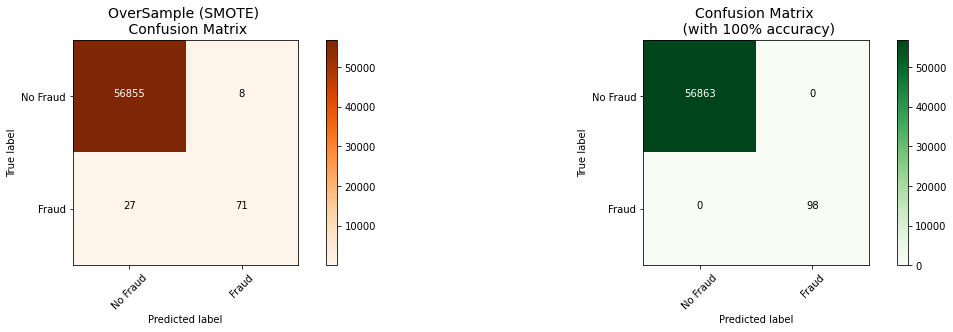

In [ ]:
oversample_smote = confusion_matrix(original_ytest, oversample_fraud_predictions)
actual_cm = confusion_matrix(original_ytest, original_ytest)
labels = ['No Fraud', 'Fraud']

fig = plt.figure(figsize=(16,8))

fig.add_subplot(221)
plot_confusion_matrix(oversample_smote, labels, title="OverSample (SMOTE) \n Confusion Matrix", cmap=plt.cm.Oranges)

fig.add_subplot(222)
plot_confusion_matrix(actual_cm, labels, title="Confusion Matrix \n (with 100% accuracy)", cmap=plt.cm.Greens)

## Conclusion:
   Implementing SMOTE on our imbalanced dataset helped us with the imbalance of our labels (more no fraud than fraud transactions). Nevertheless, I still have to state that sometimes the neural network on the oversampled dataset predicts less correct fraud transactions than our model using the undersample dataset. However, remember that the removal of outliers was implemented only on the random undersample dataset and not on the oversampled one. Also, in our undersample data our model is unable to detect for a large number of cases non fraud transactions correctly and instead, misclassifies those non fraud transactions as fraud cases. Imagine that people that were making regular purchases got their card blocked due to the reason that our model classified that transaction as a fraud transaction, this will be a huge disadvantage for the financial institution. The number of customer complaints and customer disatisfaction will increase. The next step of this analysis will be to do an outlier removal on our oversample dataset and see if our accuracy in the test set improves.
